<a href="https://colab.research.google.com/github/armanhak/NLP/blob/main/Lab2_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
Ner_dataset.csv содержит номер предложения, слова, части речи и теги для задачи NER.

In [3]:
data = pd.read_csv('ner_dataset.csv', encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
print(data.shape)
data.head(10)

(1048575, 3)


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [7]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

Получим уникальные слова и уникальные теги. Позже нам нужно дополнить предложения максимальной длиной. Для этого мы используем слово «PADword».

In [60]:
words = set(data['Word'].unique())
words.add('PADword')
n_words = len(words)
n_words

35179

In [61]:
tags = data["Tag"].unique().tolist()
n_tags = len(tags)
n_tags

17

Распределение тегов

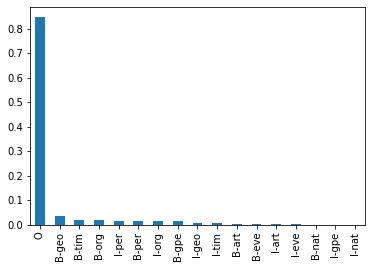

In [62]:
data["Tag"].value_counts(normalize=True).plot(kind='bar')

Создаем класс для более удобной работы с нашими данными 

In [63]:
class SentenceGetter(object):    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Преобразуем предложение в список кортежей (слово, тег)

In [64]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


Кол-во предложений

In [65]:
sentences = getter.sentences
len(sentences)

47959


In [66]:
largest_sen = max(len(sen) for sen in sentences)
print(f'Кол-во слов в самом длинном предложении: {largest_sen}')

Кол-во слов в самом длинном предложении: 104


Распределение длин предложений


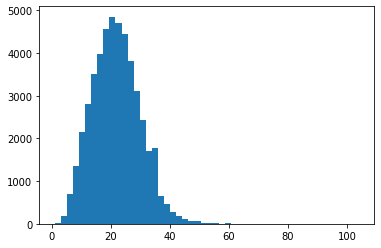

In [67]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [68]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

17636
1


максиальную длину предложения задаем 50. Те предложения, у которых длина меньше 50, то заполним словом 'PADword'

In [82]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for s in X:
    if len(s)>max_len:
        new_X.append(s[:max_len])
    else:
        s_pad = s+ ['PADword' for i in range(max_len-len(s))]
        new_X.append(s_pad)

Добавим индекси меток (тегов) в массив

In [89]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [220]:
from sklearn.model_selection import train_test_split
(X_tr, 
 X_te,
 y_tr, 
 y_te) = train_test_split(new_X, y,
                          test_size=0.1,
                          random_state=785657)
 
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]

y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_te = y_te.reshape(y_te.shape[0], y_te.shape[1], 1)

## Fine tune

In [ ]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
import tensorflow_hub as hub

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


In [96]:
batch_size = 32
tf.disable_v2_behavior()
sess = tf.Session()
K.set_session(sess)

### load Elmo

In [102]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2",   trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [182]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 lambda_9 (Lambda)              (32, None, 1024)     0           ['input_7[0][0]']                
                                                                                                  
 bidirectional_12 (Bidirectiona  (32, None, 1024)    6295552     ['lambda_9[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (32, None, 1024)    6295552     ['bidirectional_12[0][0]'] 

In [108]:
%%time
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

CPU times: user 129 ms, sys: 869 µs, total: 129 ms
Wall time: 200 ms


In [110]:
history = model.fit(np.array(X_tr), 
                    y_tr,
                    validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, 
                    epochs=3, 
                    verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/3
38816/38816 [==============================] - ETA: 0s - loss: 0.0626 - acc: 0.9819

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


38816/38816 [==============================] - 1464s 38ms/sample - loss: 0.0626 - acc: 0.9819 - val_loss: 0.0421 - val_acc: 0.9868
Epoch 2/3
38816/38816 [==============================] - 1470s 38ms/sample - loss: 0.0409 - acc: 0.9868 - val_loss: 0.0395 - val_acc: 0.9871
Epoch 3/3
38816/38816 [==============================] - 1455s 37ms/sample - loss: 0.0340 - acc: 0.9886 - val_loss: 0.0378 - val_acc: 0.9879


### Evaluate

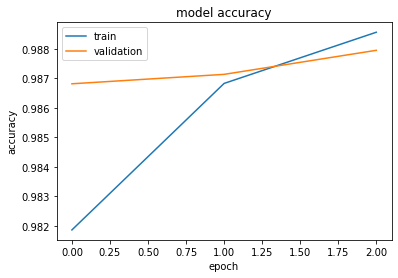

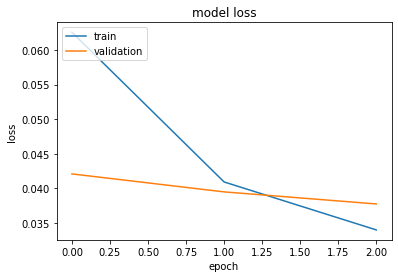

In [186]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [205]:
model.evaluate(x = np.array(X_te)[:batch_size*149], y = y_te[:batch_size*149], batch_size=batch_size)

[0.04178819434729798, 0.9865814]

Модель обучалась достаточно хорошо,accuracy на тестовой выборке 98.6 %

In [134]:
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [224]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2tag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2tag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2tag(test_pred)
test_labels = test2tag(y_te[:149*32,:,0])

In [243]:
i = 100
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:13} {:15} {}".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}{:15} {}".format(w, tags[pred], tags[true[0]]))

Word          Predicted tag   True tag
Police         O               O
say            O               O
the            O               O
bomber         O               O
blew           O               O
himself        O               O
by             O               O
a              O               O
passenger      O               O
bus            O               O
near           O               O
Tirah          B-geo           B-geo
market         O               O
.              O               O
